# Transfer learning in image classification
In this notebook we will use transfer learning and take pre-trained model from google's Tensorflow Hub and re-train that on flowers dataset. Using pre-trained model saves lot of time and computational budget for new classification problem at hand

In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import datasets, layers, models

Make predictions using ready made model (without any training

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

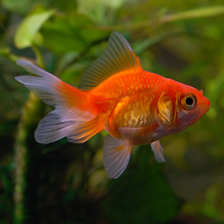

In [3]:
gold_fish = Image.open("goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish


In [4]:
np.array(gold_fish)

array([[[ 72,  85,  18],
        [ 80,  95,  23],
        [ 89, 107,  30],
        ...,
        [ 84, 100,   1],
        [ 82,  98,   1],
        [ 79,  94,   0]],

       [[ 73,  85,  21],
        [ 83,  97,  28],
        [ 90, 108,  33],
        ...,
        [ 82,  97,   1],
        [ 80,  95,   1],
        [ 77,  92,   0]],

       [[ 73,  85,  22],
        [ 80,  94,  26],
        [ 88, 106,  33],
        ...,
        [ 81,  96,   1],
        [ 79,  94,   2],
        [ 76,  91,   1]],

       ...,

       [[ 14,  28,   4],
        [ 13,  29,   5],
        [ 13,  31,   6],
        ...,
        [ 40,  56,  10],
        [ 40,  57,   9],
        [ 41,  57,   8]],

       [[ 16,  32,   4],
        [ 15,  34,   5],
        [ 14,  35,   5],
        ...,
        [ 35,  52,  12],
        [ 36,  53,  11],
        [ 36,  53,   9]],

       [[ 17,  37,   3],
        [ 18,  39,   5],
        [ 14,  38,   3],
        ...,
        [ 29,  46,  11],
        [ 30,  47,  10],
        [ 30,  48,   9]]

In [5]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [6]:
result = classifier.predict(gold_fish[np.newaxis, ...])


In [7]:
result

array([[ 0.22107825,  2.0497658 ,  9.6228075 , ..., -1.46193   ,
        -0.28231013, -0.25915977]], dtype=float32)

In [8]:
result.shape

(1, 1001)

In [9]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [10]:
image_labels = []
with open ("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [11]:
image_labels[predicted_label_index]

'goldfish'

In [12]:
data_dir='.\\datasets\\flower_photos'

In [13]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [14]:
flowers_images_dict = {
    'roses' : list(data_dir.glob('roses/*')),
    'tulips' : list(data_dir.glob('tulips/*')),
    'dandelion' : list(data_dir.glob('dandelion/*')),
    'sunflowers' : list(data_dir.glob('sunflowers/*')),
    'daisy' : list(data_dir.glob('daisy/*'))
}

In [15]:
flowers_labels_dict = {
    'roses' : 0,
    'tulips' : 1,
    'dandelion' : 2,
    'sunflowers' : 3,
    'daisy' : 4
    
}

# Read flowers images from disk into numpy array using opencv

In [16]:
x, y = [], []
for flower_name, images in flowers_images_dict.items():
     for image in images:
            img = cv2.imread(str(image))
            resized_img = cv2.resize(img, IMAGE_SHAPE)
            x.append(resized_img)
            y.append(flowers_labels_dict[flower_name])
  

In [17]:
x.shape

AttributeError: 'list' object has no attribute 'shape'

In [17]:
x = np.array(x)
y = np.array(y)

In [18]:
#you see the uses of np.array in cell 29-31...
x.shape

(3669, 224, 224, 3)

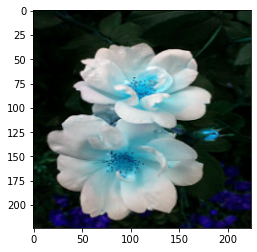

In [19]:
plt.imshow(x[0])

Train test split

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x , y,random_state=0)

Preprocessing: scale images

In [21]:
x_train_scaled = X_train / 255
x_test_scaled = X_test /255

Make prediction using pre-trained model on new flowers datase

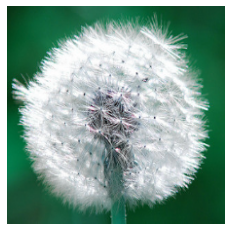

In [22]:
plt.axis('off')
plt.imshow(x_train_scaled[0])

In [23]:
predicted = classifier.predict(np.array([x[0],x[1],x[2]]))
predicted = np.argmax(predicted, axis =1)
predicted

array([795, 880, 795], dtype=int64)

In [24]:
image_labels[795]

'shower curtain'

# Now take pre-trained model and retrain it using flowers images

In [26]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [27]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(x_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 234s 1s/step - loss: 0.8233 - acc: 0.6885
Epoch 2/5
86/86 [==============================] - 116s 1s/step - loss: 0.4144 - acc: 0.8564
Epoch 3/5
86/86 [==============================] - 130s 1s/step - loss: 0.3210 - acc: 0.8928
Epoch 4/5
86/86 [==============================] - 116s 1s/step - loss: 0.2684 - acc: 0.9124
Epoch 5/5
86/86 [==============================] - 121s 1s/step - loss: 0.2376 - acc: 0.9328


In [31]:
model.evaluate(x_test_scaled,y_test)

29/29 [==============================] - 98s 1s/step - loss: 0.3598 - acc: 0.8693


[0.3598007261753082, 0.8692810535430908]